#Stack overflow tag prediction
##Problem statement
to predict the tag based on the question

##Bussiness problem
with the help of atomating the tag prediction task we can easily distingwish the question based on the tag and give accurate results to the user
1. for eg is a user is finding a question of a particular language suppose c then we can give only those results with tag contaning c tag rather than giving c++ or python results

##metrics
f1 score it is used for multiclass or multilable problem

#Importing the data from google drive

In [59]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
 1A1Q.py			    2SD21EE048.pdf   Classroom		    Resume.gdoc
 1A2Q.py			    Answers.csv     'Colab Notebooks'	    tag.png
 1A3Q.py			    archive.zip     'Getting started.pdf'   Tags.csv
 1Assignement2SD21EE048.pdf	   'Assignement 2'   Questions.csv
'2SD21EE048 (Assignement 1).gdoc'  'Assignement 3'   rapidsai-csp-utils


#Importing the libraries

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pprint
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


#Loading the data, 1000 datapoints

In [61]:
question=pd.read_csv("Questions.csv",encoding="ISO-8859-1", nrows=1000)
tags = pd.read_csv("Tags.csv", encoding="ISO-8859-1",nrows=1000, dtype={'Tag': str})

In [62]:
question.shape

(1000, 7)

In [63]:
tags.shape

(1000, 2)

In [64]:
question.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [65]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


#Formating and joining the question and tags dataset

In [66]:
tags['Tag']=tags['Tag'].astype(str)
tags=tags.groupby('Id')['Tag'].apply(lambda tags: ' '.join(tags))
tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
358,33150,c# asp.net vb.net custom-server-controls web-c...
359,33250,c# asp.net active-directory
360,33390,linq-to-sql .net-3.5
361,33510,modularity compiled interpreted


In [67]:
tags = pd.DataFrame({'Id':tags.index, 'Tags':tags.values})
tags['Tags'] = tags['Tags'].apply(lambda x: ', '.join(x.split()))
tags['Tags'] = tags['Tags'].apply(lambda x: x.split(', '))
tags.head()

,Id,Tags
0,80,"[flex, actionscript-3, air]"
1,90,"[svn, tortoisesvn, branch, branching-and-merging]"
2,120,"[sql, asp.net, sitemap]"
3,180,"[algorithm, language-agnostic, colors, color-s..."
4,260,"[c#, .net, scripting, compiler-construction]"


In [68]:
tags.shape

(363, 2)

In [69]:
question.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate','Score'], inplace=True)
data = pd.merge(question, tags, on='Id')
data.head()

,Id,Title,Body,Tags
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,180,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"


#EDA

In [70]:
'''tag_counts = {}
for tag_list in data["Tags"]:
    for tag in tag_list:
        tag = str(tag)
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

plt.figure(figsize=(10, 6))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Distribution of Tag Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()'''

'tag_counts = {}\nfor tag_list in data["Tags"]:\n    for tag in tag_list:\n        tag = str(tag)\n        if tag in tag_counts:\n            tag_counts[tag] += 1\n        else:\n            tag_counts[tag] = 1\n\nplt.figure(figsize=(10, 6))\nplt.bar(tag_counts.keys(), tag_counts.values())\nplt.xlabel(\'Tags\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Distribution of Tag Frequencies\')\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()'

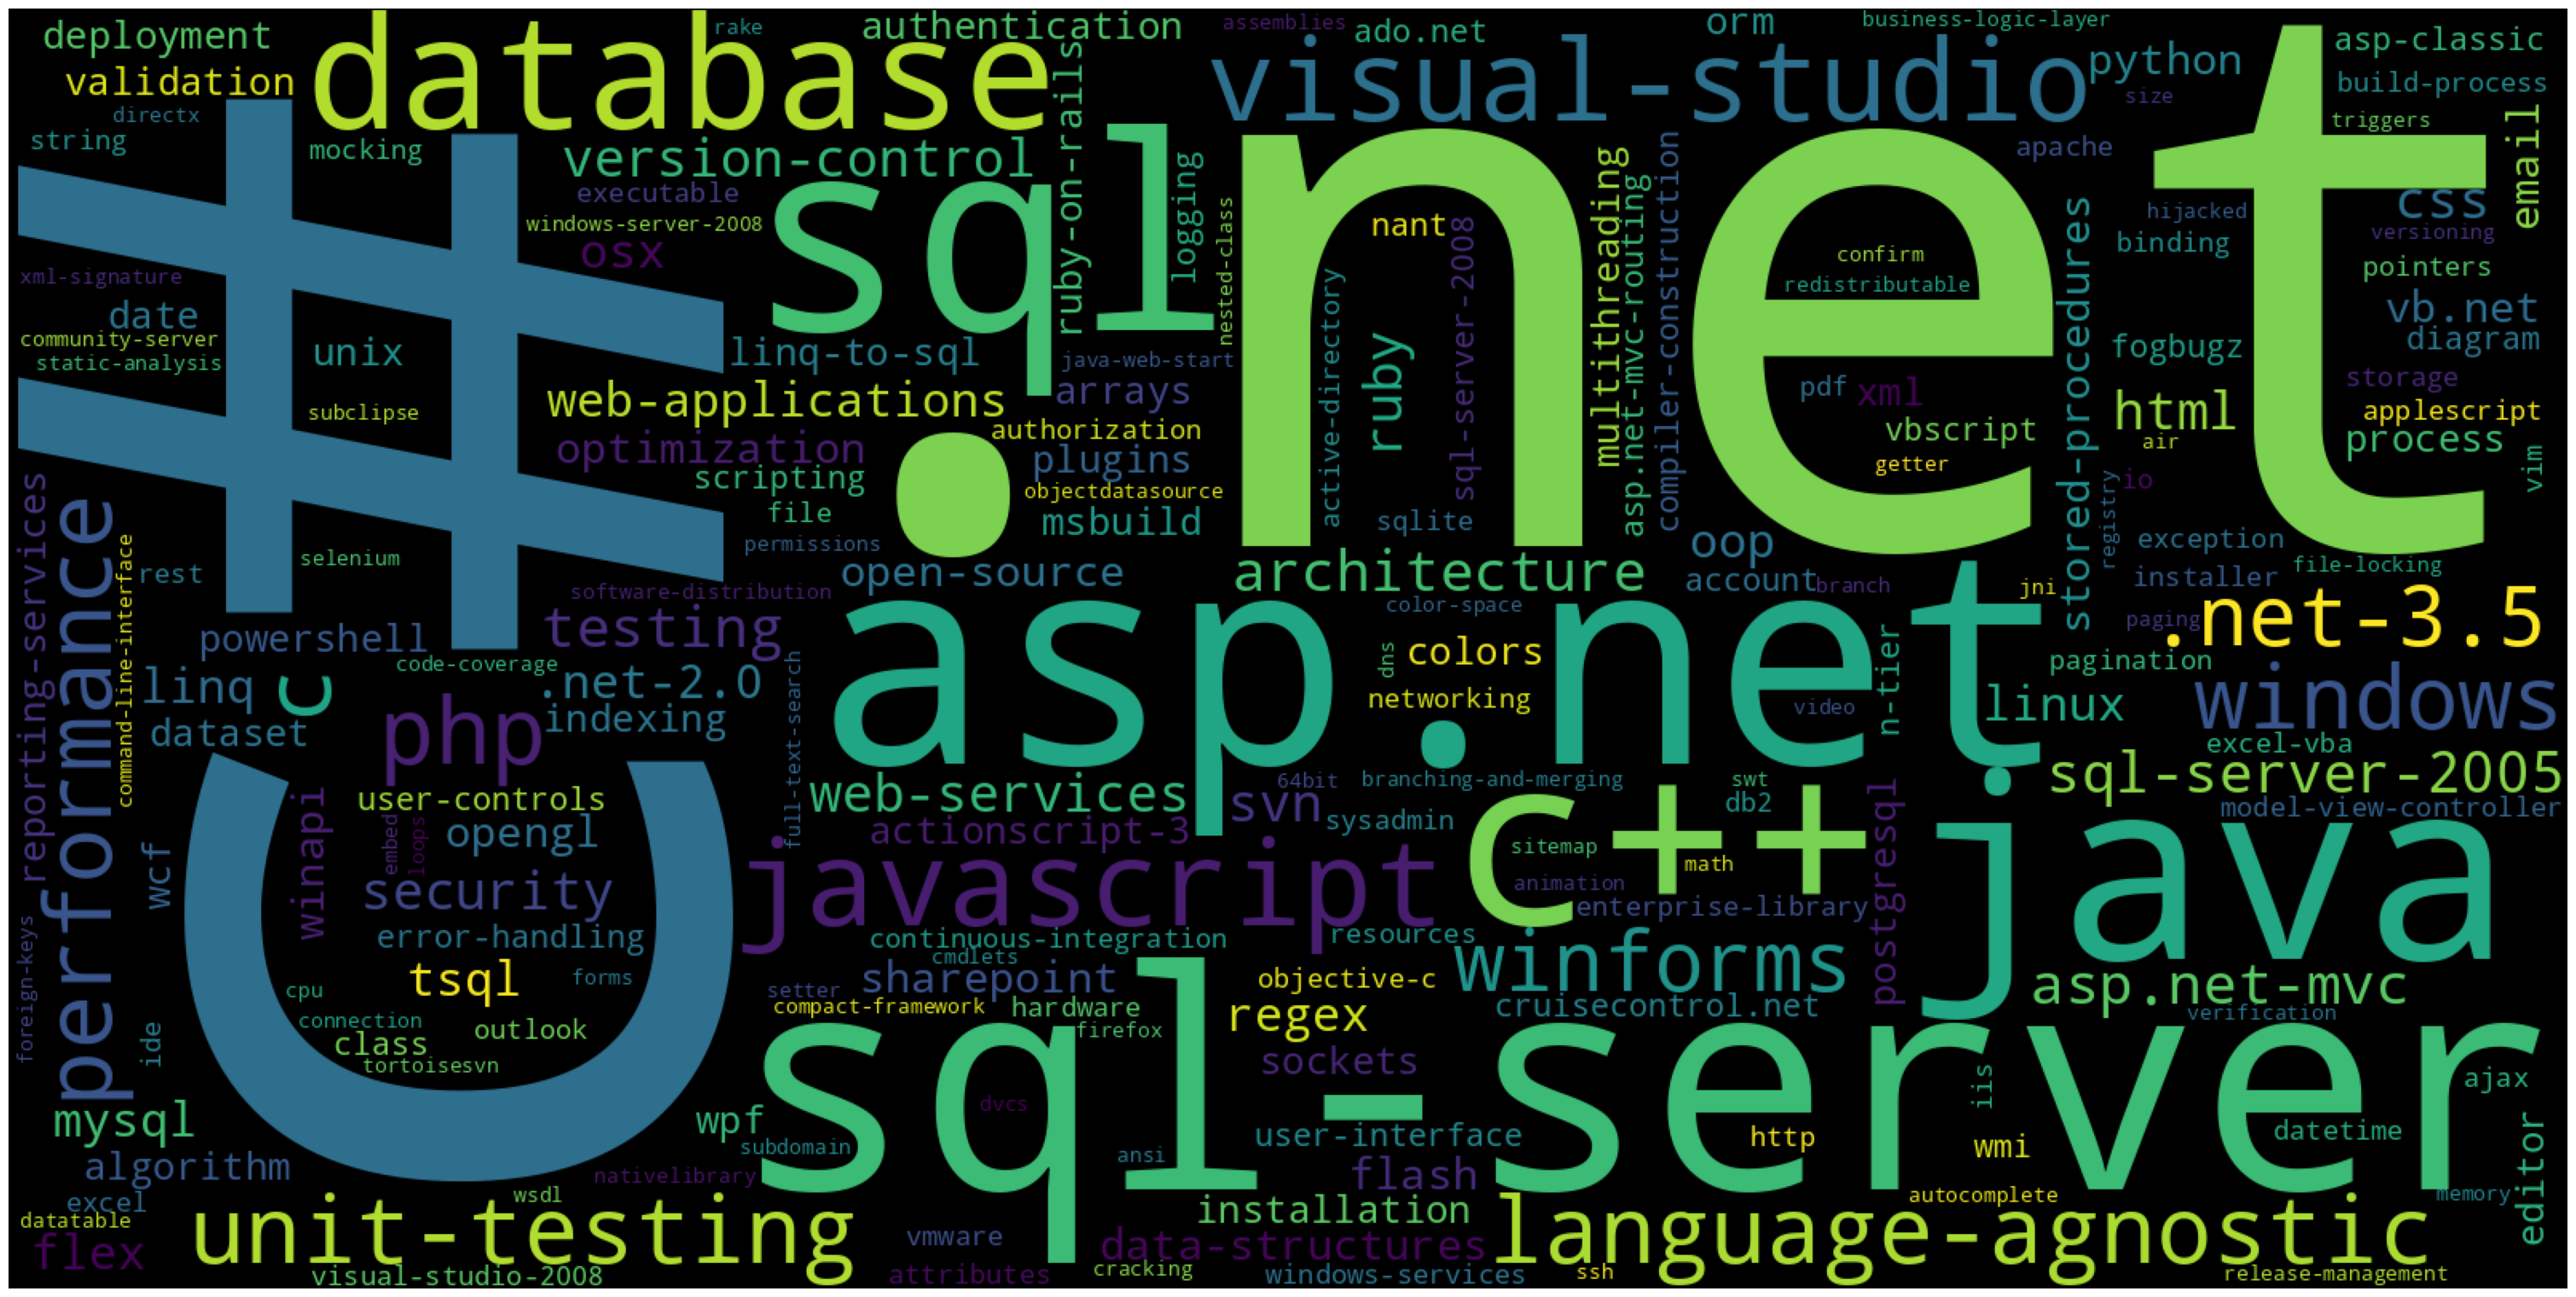

In [71]:
tag_counts = {}
for tag_list in data["Tags"]:
    for tag in tag_list:
        tag_counts[tag] = tag_counts.get(tag, 0) + 1

wordcloud = WordCloud(
    background_color='black',
    width=1600,
    height=800,
).generate_from_frequencies(tag_counts)

plt.figure(figsize=(30, 20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("tag.png")
plt.show()

In [72]:
pprint.pp(tag_counts)

{'flex': 5,
 'actionscript-3': 3,
 'air': 1,
 'svn': 6,
 'tortoisesvn': 1,
 'branch': 1,
 'branching-and-merging': 1,
 'sql': 19,
 'asp.net': 23,
 'sitemap': 1,
 'algorithm': 3,
 'language-agnostic': 10,
 'colors': 3,
 'color-space': 1,
 'c#': 46,
 '.net': 43,
 'scripting': 2,
 'compiler-construction': 2,
 'c++': 17,
 'oop': 5,
 'class': 2,
 'nested-class': 1,
 'web-services': 6,
 'sql-server': 24,
 'sql-server-2005': 7,
 'deployment': 3,
 'release-management': 1,
 'visual-studio': 11,
 'versioning': 1,
 'windows': 9,
 'registry': 1,
 'installation': 3,
 'database': 12,
 'loops': 1,
 'connection': 1,
 'file-locking': 1,
 'unix': 3,
 'size': 1,
 'msbuild': 3,
 'cruisecontrol.net': 2,
 'web-applications': 5,
 'dns': 1,
 'subdomain': 1,
 'account': 2,
 '.net-3.5': 8,
 'nant': 2,
 'windows-server-2008': 1,
 'sql-server-2008': 2,
 'unit-testing': 10,
 'testing': 7,
 'version-control': 6,
 'postgresql': 3,
 'stored-procedures': 4,
 'triggers': 1,
 'dataset': 3,
 'datatable': 1,
 'asp-classic

In [73]:
len(tag_counts) #There total of 471 unique tags

471

In [74]:
max_tag = max(tag_counts, key=tag_counts.get)
max_count = tag_counts[max_tag]

print(f'{max_tag} has repeated {max_count}')

c# has repeated 46


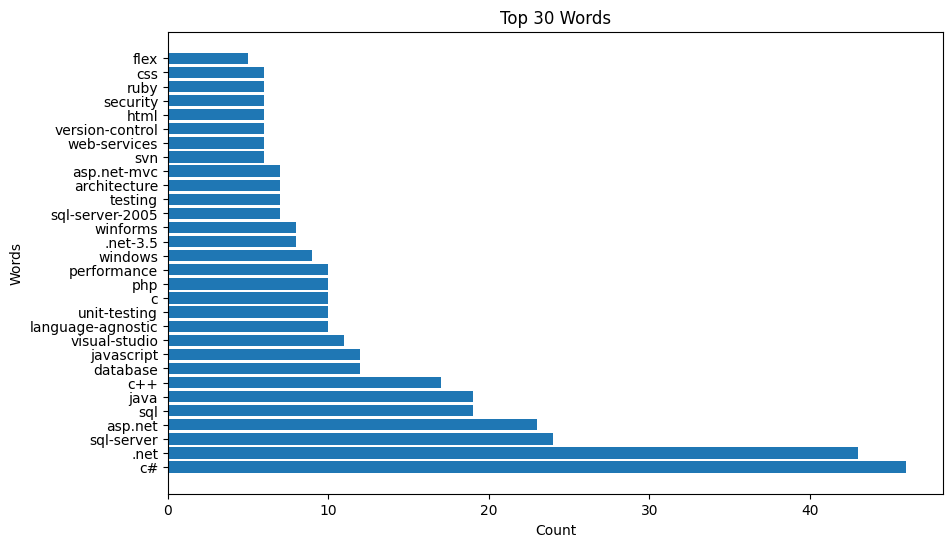

In [75]:
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)
top_30_tags = sorted_tags[:30]
words = [tag[0] for tag in top_30_tags]
counts = [tag[1] for tag in top_30_tags]

plt.figure(figsize=(10, 6))
plt.barh(words, counts)
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 30 Words')
plt.show()

In [76]:
data.isnull().sum() #Checking if any feild has null values
#No null values in any datafield

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [77]:
data.shape

(363, 4)

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      363 non-null    int64 
 1   Title   363 non-null    object
 2   Body    363 non-null    object
 3   Tags    363 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.5+ KB


In [79]:
duplicates = data[data.duplicated(subset=['Title', 'Body'])]

len(duplicates) #There are no duplicates rows

0

In [80]:
data.head(1)

,Id,Title,Body,Tags
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"


#Data cleaning

In [81]:
import nltk
nltk.download('stopwords')
def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Convert to lowercase
    text = text.lower()

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove stopwords except 'c'
    stop_words = set(stopwords.words('english'))
    stop_words.discard('c')
    words = [word for word in text.split() if word not in stop_words]
    text = ' '.join(words)

    # Stem words
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(words)

    return text

# Apply preprocessing to 'Title' and 'Body' columns
data['Title'] = data['Title'].apply(preprocess_text)
data['Body'] = data['Body'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-81-1171eabe7c1c>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [82]:
data.head(1)

,Id,Title,Body,Tags
0,80,sqlstatementexecut multipl queri one statement,ive written databas generat script sql want ex...,"[flex, actionscript-3, air]"


#Tfidf
tfidf convert words in vectors based on the importance of the word in whole of the word corpus

In [86]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
tfidf=TfidfVectorizer(analyzer='word',max_features=471)

#Train Test split
Splitting 80% data into train and 20% data into test randomly

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
# Generate a synthetic multilabel dataset
X, y = make_multilabel_classification(n_samples=1000, n_features=20, n_classes=5, n_labels=2, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#LabelPowerSet
it transform multilable classification problem into to multiclass problem

In [88]:
!pip install scikit-multilearn
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import f1_score

#Randomforst with lablepowerset
base_classifier = RandomForestClassifier()
lp_classifier = LabelPowerset(classifier=base_classifier)
lp_classifier.fit(X_train, y_train)
y_pred = lp_classifier.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1 score: {f1_micro:.4f}")

Micro-average F1 score: 0.6843


In [89]:
from sklearn.svm import SVC

#SVM with lablepowerset
base_classifier = SVC(kernel='linear', probability=True)
lp_classifier = LabelPowerset(classifier=base_classifier)
lp_classifier.fit(X_train, y_train)
y_pred = lp_classifier.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1 score: {f1_micro:.4f}")

Micro-average F1 score: 0.7387


In [99]:
from sklearn.naive_bayes import MultinomialNB

#MultinomialNB with lablepowerset
base_classifier = MultinomialNB()
lp_clf = LabelPowerset(classifier=base_classifier)
lp_clf.fit(X_train, y_train)
y_pred = lp_clf.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1 score: {f1_micro:.4f}")

Micro-average F1 score: 0.7983


In [100]:
from sklearn.ensemble import GradientBoostingClassifier

#gbdt with lablepowerset
clf = GradientBoostingClassifier()
clf1 = LabelPowerset(classifier=clf)
clf1.fit(X_train,y_train)
y_pred1= clf1.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1 score: {f1_micro:.4f}")

Micro-average F1 score: 0.7983


#One vs Rest
*  Suppose there are 3 class x,y,z
*  onevsRest fit one class vs all other class
1. x vs y,z
2. y vs x,z
3. z vs x,y

In [92]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [93]:
from sklearn.neighbors import KNeighborsClassifier

#knn with onevsrest
knn = KNeighborsClassifier(n_neighbors=5)
ovr = OneVsRestClassifier(knn)
ovr.fit(X_train, y_train)
y_pred = ovr.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1 score: {f1_micro:.4f}")

Micro-average F1 score: 0.7165


In [94]:
from sklearn.naive_bayes import MultinomialNB

#multinomialNB with onevsrest
nb = MultinomialNB()
ovr = OneVsRestClassifier(nb)
ovr.fit(X_train, y_train)
y_pred = ovr.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1 score: {f1_micro:.4f}")

Micro-average F1 score: 0.7229


In [95]:
from sklearn.ensemble import RandomForestClassifier

#randomforest with onevsrest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
ovr = OneVsRestClassifier(rf)
ovr.fit(X_train, y_train)
y_pred = ovr.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1 score: {f1_micro:.4f}")

Micro-average F1 score: 0.7309


In [96]:
from sklearn.svm import LinearSVC

#svm with onevsrest
linear_svc = LinearSVC(max_iter=1000)
ovr = OneVsRestClassifier(linear_svc)
ovr.fit(X_train, y_train)
y_pred = ovr.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1 score: {f1_micro:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Micro-average F1 score: 0.7330


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [97]:
from sklearn.ensemble import GradientBoostingClassifier

#gbdt with onevsrest
gbdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
ovr = OneVsRestClassifier(gbdt)
ovr.fit(X_train, y_train)
y_pred = ovr.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1 score: {f1_micro:.4f}")

Micro-average F1 score: 0.7550


In [98]:
from sklearn.linear_model import LogisticRegression

#logisticregression with onevsrest
log_reg = LogisticRegression(max_iter=1000)
ovr = OneVsRestClassifier(log_reg)
ovr.fit(X_train, y_train)
y_pred = ovr.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1 score: {f1_micro:.4f}")

Micro-average F1 score: 0.7426


#RESULT
1. OnevsRest, lablepowerset both give good f1 score
2. lablepowerset
i. randomforest (0.6645)
ii. gbdt (0.7983)
iii. svm (0.7387)
iv. MultinomialNB (0.7983)
3. Model used are -- OnevsRest
i. knn (0.7165)
ii. linearsvm (0.7380)
iii. randomforest (0.7309)
iv. gbdt (0.7550)
v. logistic regression (0.7426)
vi. multinomialNB (0.7229)
4. gbdt and MultinomialNB with lablepowerset is the best model with f1 score of 0.7983 == 0.8 (Best f1 score is 1 and worst is 0)
5. All the model work in the range of 0.7 f1 score
6. MultinomialNB takes less time to train than gbdt so overall the best model is MultinomialNB with f1 score of 0.7983 == 0.8